In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 31.47 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms : {manual_transforms}")

Manually created transforms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
BATCH_SIZE = 32

train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=manual_transforms,batch_size=BATCH_SIZE)

train_dataloader, test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fae6d671c50>,
 ['pizza', 'steak', 'sushi'])

In [10]:
image_batch,label_batch = next(iter(train_dataloader))

image,label = image_batch[0] , label_batch[0]

image.shape,label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

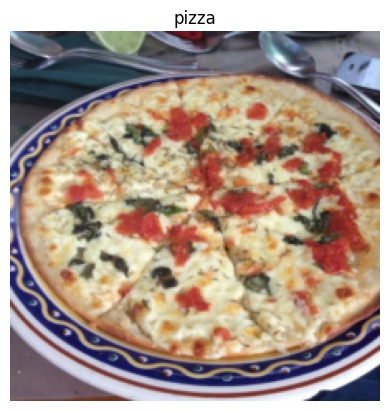

In [11]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [13]:
height = 224
width = 224
color_channels =3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)

print(f"Number of patches (N) with image height (H={height}),width (W={width}) and patch size (P={patch_size}) : {number_of_patches}")

Number of patches (N) with image height (H=224),width (W=224) and patch size (P=16) : 196


In [14]:
embedding_layer_input_shape = (height,width,color_channels)
embedding_layer_output_shape = (number_of_patches,patch_size**2*color_channels)

print(f"Input shape (single 2D image) : {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches ): {embedding_layer_output_shape}")

Input shape (single 2D image) : (224, 224, 3)
Output shape (single 2D image flattened into patches ): (196, 768)


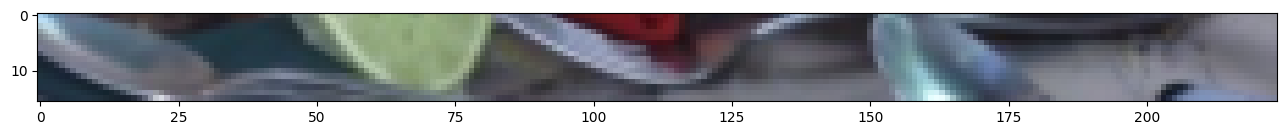

In [20]:
patch_size = 16
image_permuted = image.permute(1,2,0)

plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row : 14.0
Patch size : 16 pixels x 16 pixels


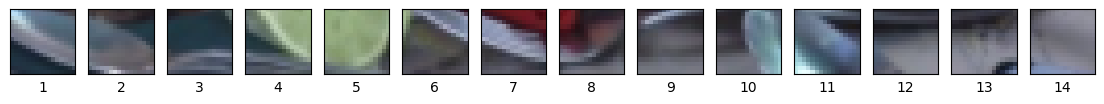

In [24]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size ==0 , "Image size must be divisible by patch size"
print(f"Number of patches per row : {num_patches}\nPatch size : {patch_size} pixels x {patch_size} pixels")

fig,axs = plt.subplots(nrows=1,ncols=img_size//patch_size,figsize=(num_patches,num_patches),sharex=True,sharey=True)

for i, patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row : 14.0
Patch size : 16 pixels x 16 pixels


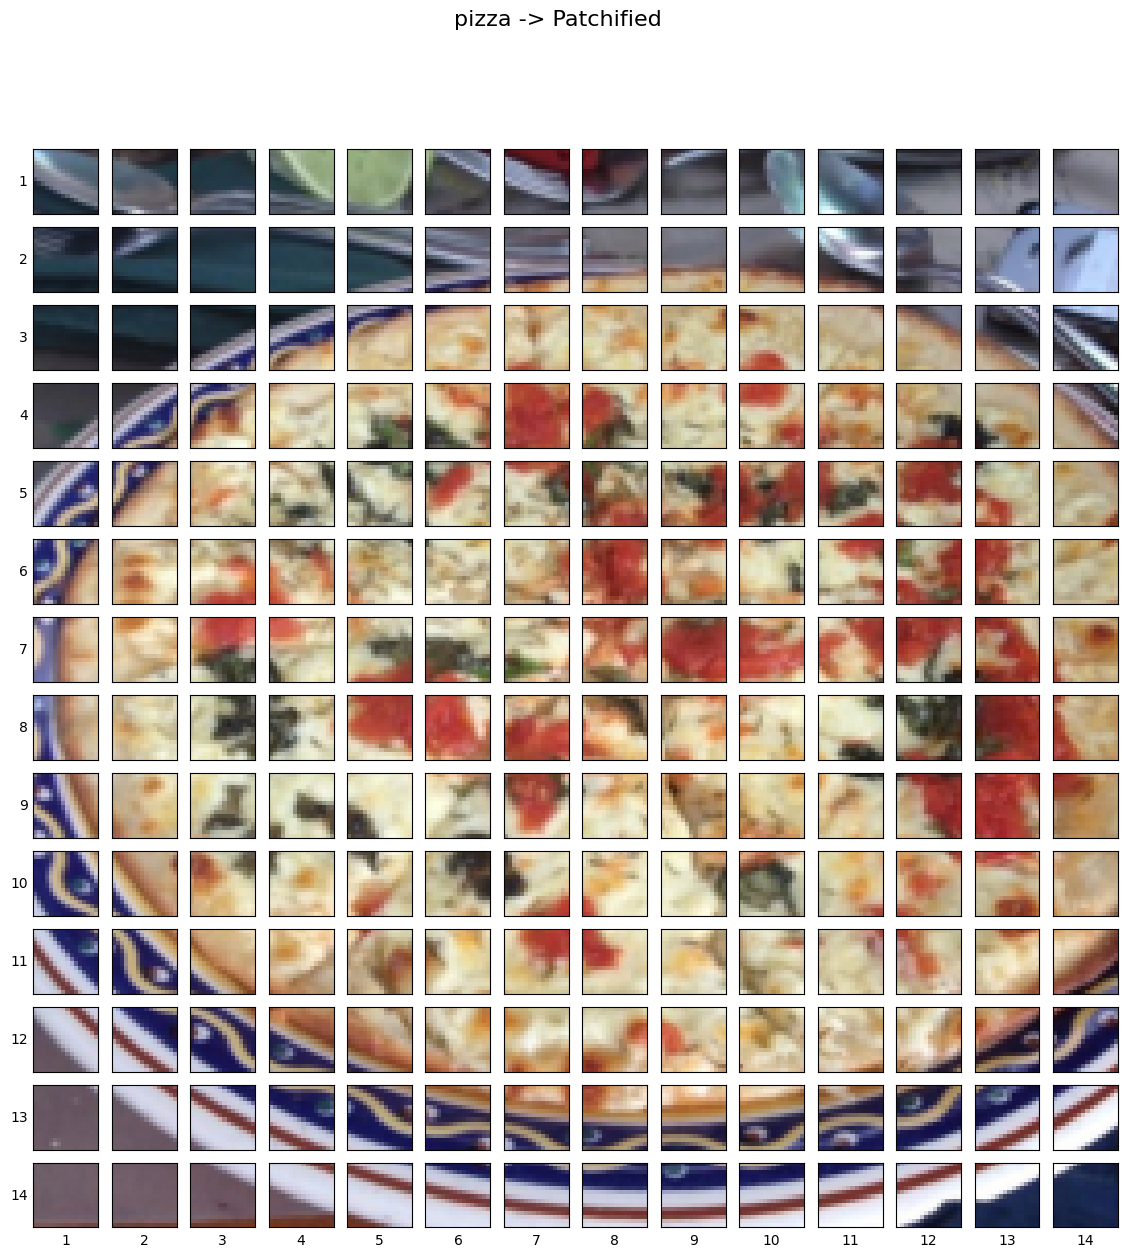

In [26]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size ==0 , "Image size must be divisible by patch size"
print(f"Number of patches per row : {num_patches}\nPatch size : {patch_size} pixels x {patch_size} pixels")

fig,axs = plt.subplots(nrows=img_size // patch_size,
                       ncols=img_size//patch_size,
                       figsize=(num_patches,num_patches),sharex=True,sharey=True)

for i, patch_height in enumerate(range(0,img_size,patch_size)):
    for j, patch_width in enumerate(range(0,img_size,patch_size)):

        axs[i,j].imshow(image_permuted[patch_height:patch_height + patch_size, patch_width:patch+patch_width + patch_size,:])
        axs[i,j].set_ylabel(i+1 , rotation="horizontal",horizontalalignment="right",verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified",fontsize=16)
plt.show()

In [27]:
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels = 3,out_channels=768,kernel_size=patch_size,stride=patch_size,padding=0)

In [28]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [29]:
flatten = nn.Flatten(start_dim=2,end_dim=3)

In [30]:
image_out_of_conv_flattened = flatten(image_out_of_conv)
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape : {image_out_of_conv_flattened_reshaped.shape} -> [batch_size,num_patches,embedding_size]")

Patch embedding sequence shape : torch.Size([1, 196, 768]) -> [batch_size,num_patches,embedding_size]


In [35]:
class PatchEmbedding(nn.Module):
    def __init__(self,in_channels=3,patch_size=16,embedding_dim=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0)

        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    def forward(self,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0 , f'Input image size must be divisible by patch size.'

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

In [36]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)

print(f"Input image shape : {image.unsqueeze(0).shape}")
patch_emdebbed_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape : {patch_emdebbed_image.shape}")

Input image shape : torch.Size([1, 3, 224, 224])
Output patch embedding shape : torch.Size([1, 196, 768])


In [38]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [39]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [40]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.2737e-01,  8.1749e-02,  3.4062e-02,  ...,  4.2828e-01,
          -2.7036e-01,  4.1517e-03],
         [-3.5813e-01, -3.4876e-02, -2.0357e-01,  ...,  3.0334e-01,
          -6.8807e-02,  1.4236e-01],
         ...,
         [-4.5931e-01,  6.5654e-02, -4.0851e-01,  ...,  3.3190e-01,
           7.4888e-04,  4.6475e-01],
         [-7.2915e-01,  4.3853e-01,  1.1846e-01,  ...,  3.1591e-01,
          -3.8844e-01,  1.4535e-02],
         [ 5.1639e-02, -7.3010e-02, -2.8630e-02,  ...,  1.3583e-01,
          -1.3112e-01,  8.9561e-02]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [42]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [43]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5726, 1.0817, 1.0341,  ..., 1.4283, 0.7296, 1.0042],
         [0.6419, 0.9651, 0.7964,  ..., 1.3033, 0.9312, 1.1424],
         ...,
         [0.5407, 1.0657, 0.5915,  ..., 1.3319, 1.0007, 1.4647],
         [0.2708, 1.4385, 1.1185,  ..., 1.3159, 0.6116, 1.0145],
         [1.0516, 0.9270, 0.9714,  ..., 1.1358, 0.8689, 1.0896]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [44]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [46]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,embedding_dim=768,num_heads=12,attn_dropout=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads,dropout=attn_dropout,batch_first=True)

    def forward(self,x):
        x = self.layer_norm(x)
        attn_output,_ = self.multihead_attn(query=x,key=x,value=x,need_weights=False)

        return attn_output


In [48]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Output shape MSA block : {patched_image_through_msa_block.shape}")

Output shape MSA block : torch.Size([1, 197, 768])


In [49]:
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim=768,mlp_size=3072,dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [50]:
mlp_block = MLPBlock(embedding_dim=768,mlp_size=3072,dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)


In [53]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,embedding_dim=768,num_heads=12,mlp_size=3072,mlp_dropout=0.1,attn_dropout=0):
        super().__init__()

        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)

    def forward(self,x):

        x = self.msa_block(x) + x

        x = self.mlp_block(x) + x

        return x


In [54]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [57]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 att_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=1000):

        super().__init__()

        assert img_size % patch_size == 0, f"image must be temuujin"

        self.num_patches = (img_size * img_size) // patch_size ** 2

        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,patch_size=patch_size,embedding_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,num_heads=num_heads,mlp_size=mlp_size,mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),nn.Linear(in_features=embedding_dim,out_features=num_classes)
        )

    def forward(self,x):

        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size,-1,-1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token,x),dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:,0])

        return x

In [ ]:
from going_modular.going_modular import engine

vit = ViT(num_classes =len(class_names))

optimizer = torch.optim.Adam(params=vit.parameters(),lr=3e-3,betas=(0.9,0.999),weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=vit,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4925 | train_acc: 0.4531 | test_loss: 1.9130 | test_acc: 0.2604
